# Generative Adversarial Networks

## MNIST-fashion GAN
The Fashion-MNIST dataset contains 60,000 training images (and 10,000 test images) of fashion and clothing items, taken from 10 classes. Each image is a standardized 28×28 size in grayscale (784 total pixels).

<center>
<img src="https://miro.medium.com/max/1400/0*ga9XgppZI_XULBRz">
</center>

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, Dropout, Convolution2DTranspose, Reshape, Flatten
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

Check the GPU of your machine (Tesla P100 is the highest you can get)

In [2]:
!nvidia-smi

Tue Jan  4 13:28:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    89W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
print("Num GPUs Available ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available  1


## Load the Fashion MNIST Dataset

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

## Data Preprocessing

Merge the training and testing sets, Then normalize the images from [0,255] to [0,1]

In [5]:
dataset = np.concatenate([x_train, x_test], axis = 0)
print(dataset.shape)
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

(70000, 28, 28)


Now we will reshape the data to dimensions needed by the CNN layers that's why we convert it to TensorFlow type. After that we will shuffle and batch it.

In [6]:
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

(70000, 28, 28, 1)


## Building The Generator
The generator's input is a noise vector. 

In [7]:
NOISE_DIM = 150

generator = Sequential ([
      InputLayer(input_shape=(NOISE_DIM,)),
      Dense(7*7*256),
      Reshape(target_shape=(7, 7, 256)),
      Convolution2DTranspose(256, 3, activation="LeakyReLU", strides=2, padding="same"),
      Convolution2DTranspose(128, 3, activation="LeakyReLU", strides=2, padding="same"),
      Convolution2DTranspose(1, 3, activation="sigmoid", padding="same")
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        1153      
 ranspose)                                                       
                                                        

## Building The Discriminator

In [8]:
discriminator = Sequential ([
      InputLayer(input_shape=((28, 28, 1))),
      Conv2D(256, 3, activation="relu", strides=2, padding="same"),
      Conv2D(128, 3, activation="relu", strides=2, padding="same"),
      Flatten(),
      Dense(64, activation="relu"),
      Dropout(0.2),
      Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-tr

## Optimizers

In [9]:
optimizer_g = Adam(learning_rate=0.00001, beta_1=0.5)
optimizer_d = Adam(learning_rate=0.00003, beta_1=0.5)

loss_func = BinaryCrossentropy(from_logits=True)

g_acc_metric = BinaryAccuracy()
d_acc_metric = BinaryAccuracy()

## Set Up Discriminator Training

In [10]:
def train_d_step(data):
  """ train func"""
  batch_size = tf.shape(data)[0]

  noise =  tf.random.normal(shape=(batch_size, NOISE_DIM))

  y_true = tf.concat(
      [
       tf.ones(batch_size, 1),
       tf.zeros(batch_size, 1)
      ], axis = 0
  )

  with tf.GradientTape() as tape:
    fake = generator(noise)
    x = tf.concat([data, fake], axis=0)
    y_pred = discriminator(x) # D(x)
    discriminator_loss = loss_func(y_true,  y_pred)

  grads = tape.gradient(discriminator_loss, discriminator.trainable_weights)
  optimizer_d.apply_gradients(zip(grads, discriminator.trainable_weights))

  d_acc_metric.update_state(y_true, y_pred)

  visualization_loss = {
      'discriminator_loss' : discriminator_loss,
      'discriminator_acc' : d_acc_metric.result()
  }
  
  return visualization_loss


## Set Up Generator Training

In [11]:
def train_g_step(data):
  """ train func"""
  batch_size = tf.shape(data)[0]

  noise =  tf.random.normal(shape=(batch_size, NOISE_DIM))

  y_true = tf.ones(batch_size, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise)) # D(G(Z))
    generator_loss = loss_func(y_true,  y_pred)

  grads = tape.gradient(generator_loss, generator.trainable_weights)
  optimizer_g.apply_gradients(zip(grads, generator.trainable_weights))

  g_acc_metric.update_state(y_true, y_pred)
  visualization_loss = {
      'generator_loss' : generator_loss,
      'generator_acc' : g_acc_metric.result()
  }
  
  return visualization_loss

## Visualization

In [12]:
def plot_images(model):
  """ visualize generated images as we train"""
  images = model(np.random.normal(size=(81, NOISE_DIM)))

  plt.figure(figsize=(9, 9))

  for i, image in enumerate(images):
    plt.subplot(9, 9, i+1)
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
    plt.axis('off')

  plt.show()

## Training

Epoch:0 Loss G:0.6624, Loss D:0.5372, Acc G:%2.36, Acc D:%95.36


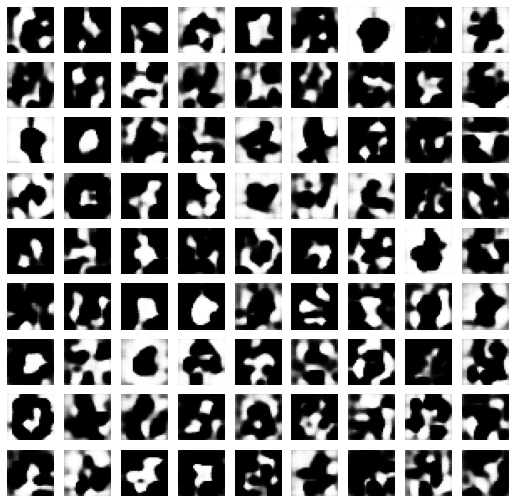

Epoch:1 Loss G:0.6744, Loss D:0.5271, Acc G:%1.37, Acc D:%97.00
Epoch:2 Loss G:0.6780, Loss D:0.5231, Acc G:%1.33, Acc D:%97.19


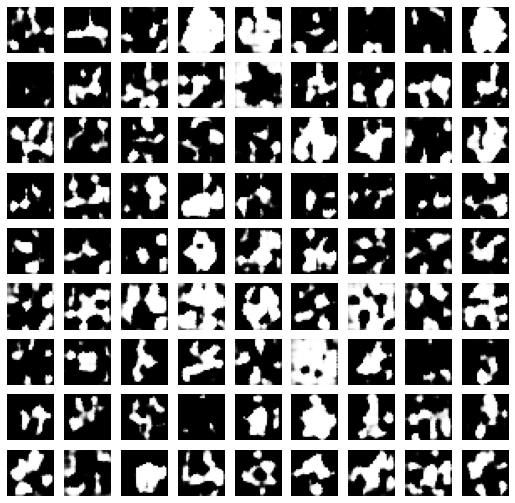

Epoch:3 Loss G:0.6822, Loss D:0.5189, Acc G:%1.23, Acc D:%97.32
Epoch:4 Loss G:0.6906, Loss D:0.5069, Acc G:%1.06, Acc D:%97.56


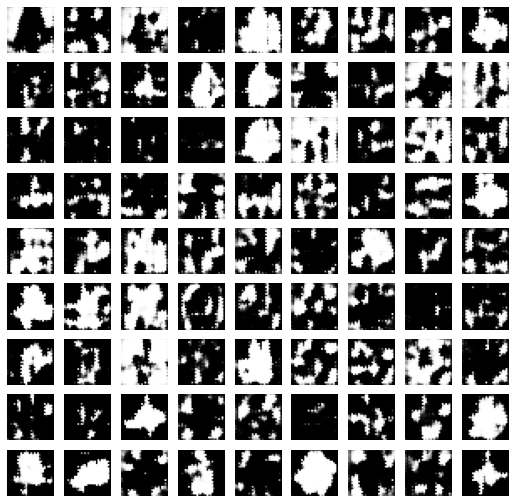

Epoch:5 Loss G:0.6838, Loss D:0.5178, Acc G:%0.96, Acc D:%97.79
Epoch:6 Loss G:0.6848, Loss D:0.5161, Acc G:%0.96, Acc D:%97.79


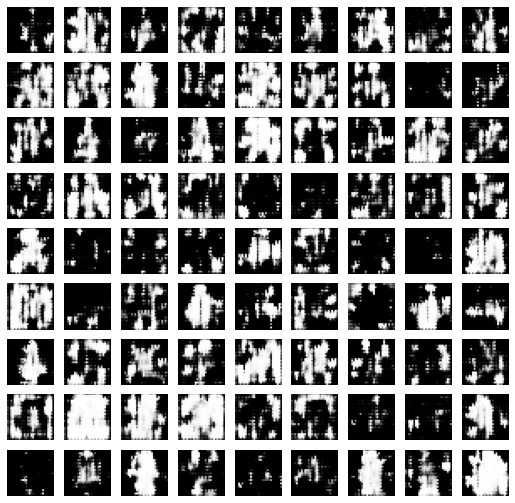

Epoch:7 Loss G:0.6644, Loss D:0.5640, Acc G:%1.12, Acc D:%97.27
Epoch:8 Loss G:0.6373, Loss D:0.6292, Acc G:%1.83, Acc D:%94.87


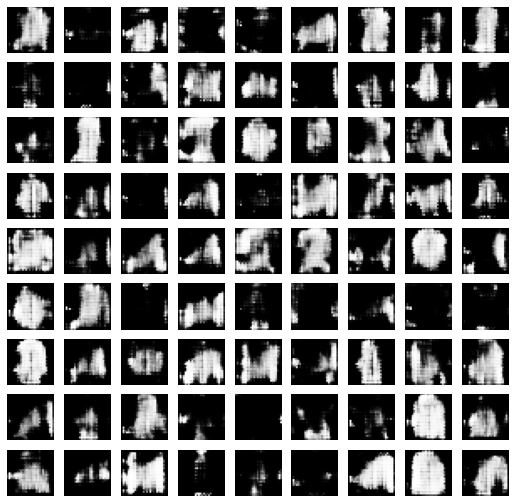

Epoch:9 Loss G:0.6392, Loss D:0.6281, Acc G:%2.61, Acc D:%92.37
Epoch:10 Loss G:0.6444, Loss D:0.6272, Acc G:%3.02, Acc D:%90.27


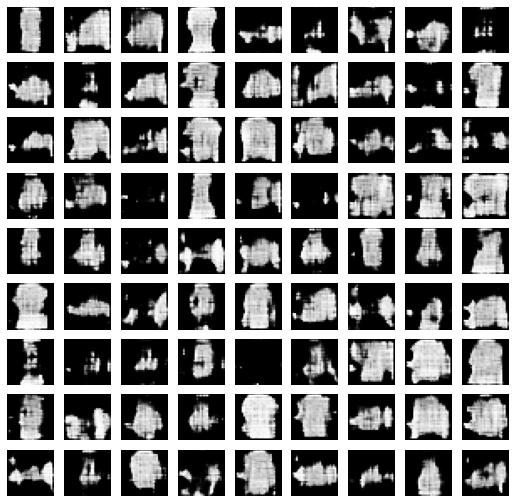

Epoch:11 Loss G:0.6456, Loss D:0.6410, Acc G:%3.26, Acc D:%88.46
Epoch:12 Loss G:0.6432, Loss D:0.6357, Acc G:%3.47, Acc D:%86.78


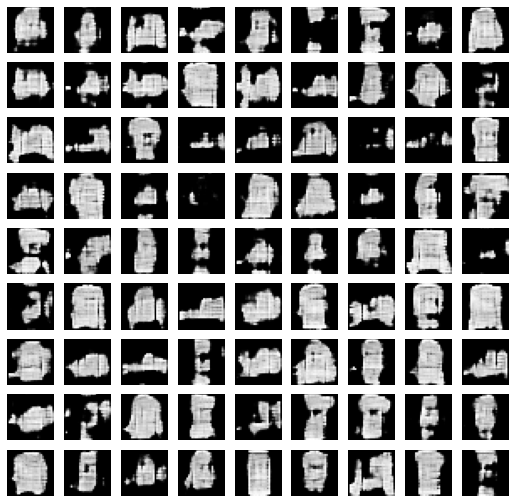

Epoch:13 Loss G:0.6424, Loss D:0.6260, Acc G:%3.65, Acc D:%85.53
Epoch:14 Loss G:0.6354, Loss D:0.6176, Acc G:%3.82, Acc D:%84.69


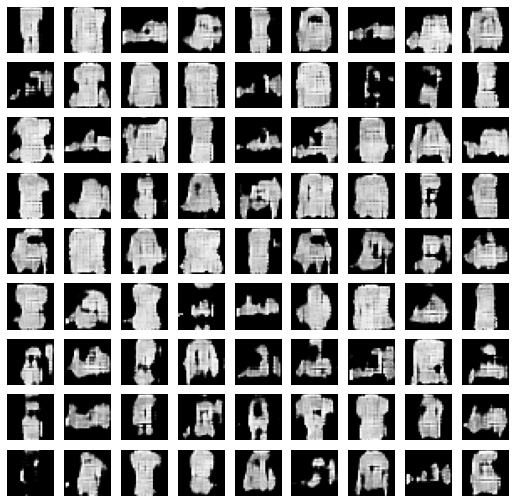

Epoch:15 Loss G:0.6351, Loss D:0.6086, Acc G:%3.98, Acc D:%84.14
Epoch:16 Loss G:0.6359, Loss D:0.6076, Acc G:%4.11, Acc D:%83.77


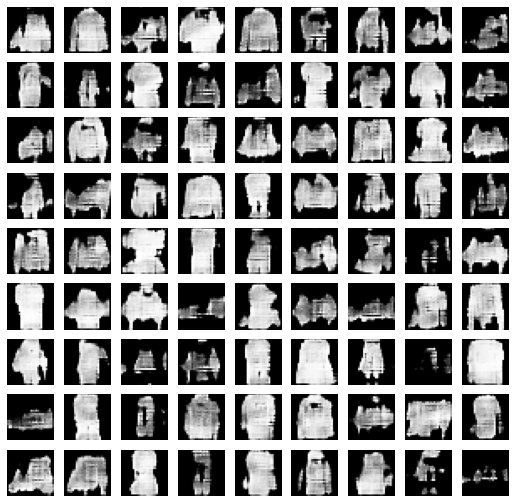

Epoch:17 Loss G:0.6379, Loss D:0.6120, Acc G:%4.24, Acc D:%83.38
Epoch:18 Loss G:0.6368, Loss D:0.6121, Acc G:%4.35, Acc D:%83.01


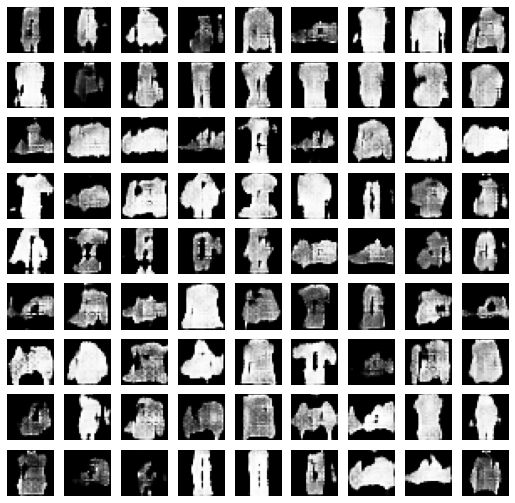

Epoch:19 Loss G:0.6365, Loss D:0.6127, Acc G:%4.47, Acc D:%82.65
Epoch:20 Loss G:0.6352, Loss D:0.6117, Acc G:%4.59, Acc D:%82.34


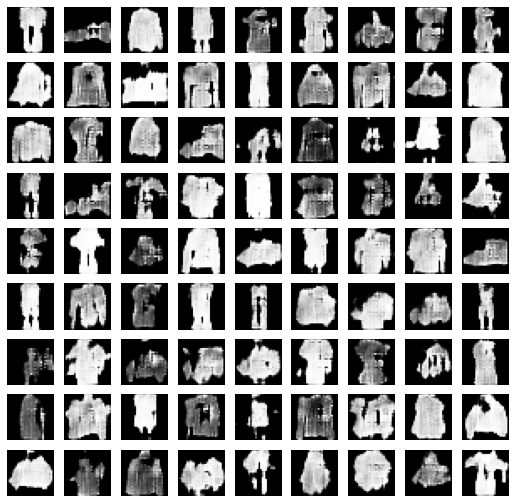

Epoch:21 Loss G:0.6349, Loss D:0.6119, Acc G:%4.73, Acc D:%82.05
Epoch:22 Loss G:0.6346, Loss D:0.6104, Acc G:%4.86, Acc D:%81.81


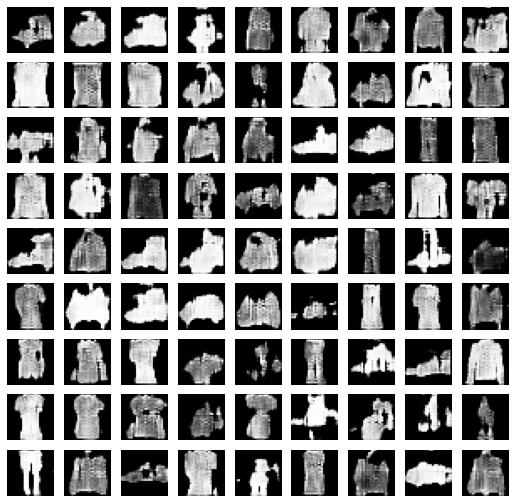

Epoch:23 Loss G:0.6352, Loss D:0.6084, Acc G:%4.96, Acc D:%81.59
Epoch:24 Loss G:0.6354, Loss D:0.6065, Acc G:%5.06, Acc D:%81.44


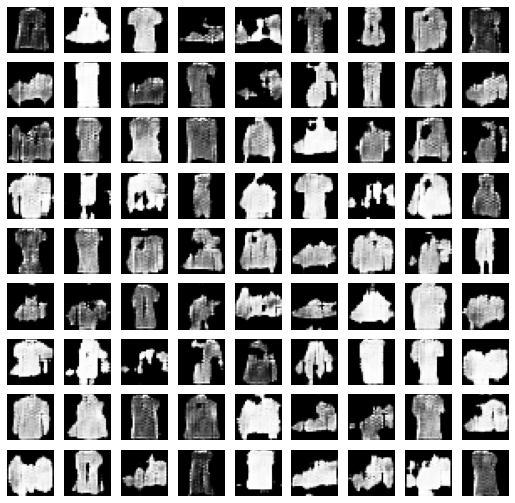

Epoch:25 Loss G:0.6366, Loss D:0.6062, Acc G:%5.14, Acc D:%81.29
Epoch:26 Loss G:0.6365, Loss D:0.6067, Acc G:%5.20, Acc D:%81.15


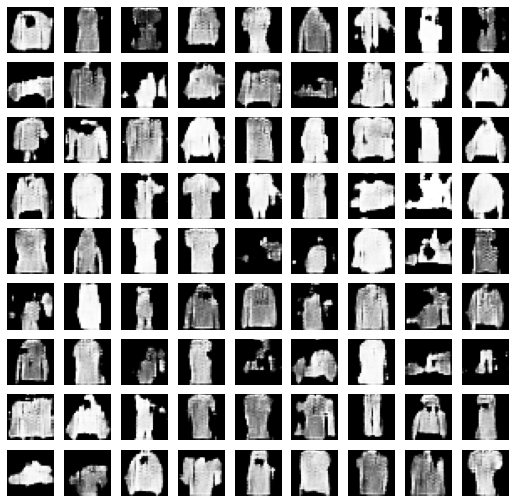

Epoch:27 Loss G:0.6380, Loss D:0.6072, Acc G:%5.27, Acc D:%81.01
Epoch:28 Loss G:0.6405, Loss D:0.6063, Acc G:%5.31, Acc D:%80.87


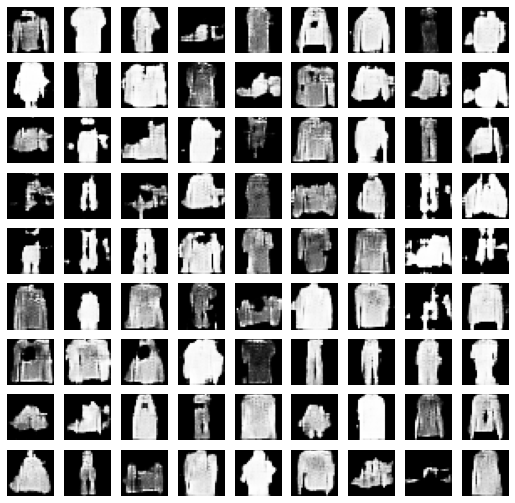

Epoch:29 Loss G:0.6415, Loss D:0.6066, Acc G:%5.35, Acc D:%80.73


In [13]:
for epoch in range(30):

  d_loss_sum = 0
  d_acc_sum = 0
  
  g_loss_sum = 0
  g_acc_sum = 0
  
  counter = 0

  for batch in dataset:
    d_loss = train_d_step(batch)

    d_loss_sum += d_loss['discriminator_loss']
    d_acc_sum += d_loss['discriminator_acc']

    g_loss = train_g_step(batch)

    g_loss_sum += g_loss['generator_loss']
    g_acc_sum += g_loss['generator_acc']

    counter += 1

  print("Epoch:{} Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      g_loss_sum / counter,
      d_loss_sum / counter,
      100 * (g_acc_sum / counter),
      100 * (d_acc_sum / counter),
  ))
  if epoch % 2 == 0:
    plot_images(generator)

## Test The Generator

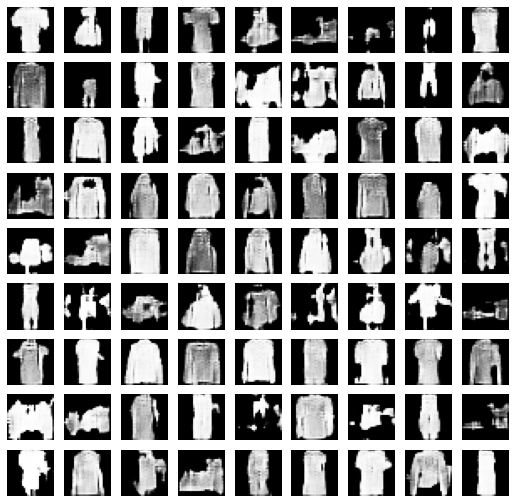

In [16]:
images = generator(np.random.normal(size=(81, NOISE_DIM)))

plt.figure(figsize=(9, 9))

for i, image in enumerate(images):
  plt.subplot(9, 9, i+1)
  plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
  plt.axis('off')

plt.show()